In [232]:
import numpy as np
from numpy import trapz
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc,flux_to_mag
import pymoc
from pymoc.io.fits import read_moc_fits

from astropy.io import registry
from astropy.table.info import serialize_method_as

In [233]:
def calistro_fit(z):
    law = 1.72*(1+z)**(-0.22)
    return(law)

In [234]:
def get_center(bins):
    centers = (bins[:-1] + bins[1:])/2
    return(centers)

In [235]:
lofar_sed_en1 = Table.read('data/lofar_sed_en1.fits')
print(len(lofar_sed_en1))
lofar_sed_en1[0]

31645


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,bayes.dust.luminosity_fritz,bayes.dust.luminosity_err_fritz,best.reduced_chi_square_fritz,bayes.dust.luminosity_skirtor,bayes.dust.luminosity_err_skirtor,best.reduced_chi_square_skirtor,radio_luminosity,q_magphys,q_agnfitter,q_fritz,q_skirtor,optical_AGN,radio_AGN,rad_excess
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,bytes

In [267]:
lofar_magphys_en1 = Table.read('data/magphys_mass_radio_limits_en1.fits')
#mask = lofar_magphys_en1['q_lim']==1E20
#lofar_magphys_en1['q_lim'][mask] = np.nan
print(len(lofar_magphys_en1))
lofar_magphys_en1[0]

144611


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,m

In [237]:
stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

mask = (stellar_mass_cat['Z_BEST']<1.0) & (stellar_mass_cat['Mass_median']>10.7)
print('there are {} sources with M>10.7 and z<1.0'.format(np.sum(mask)))

there are 29329 sources with M>10.7 and z<1.0


In [268]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_limit_en1)))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]

There are 6043 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 19682 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


measured median from the detections is: 1.7773914927843641
measured median using survival analysis is: 1.7773914927843641


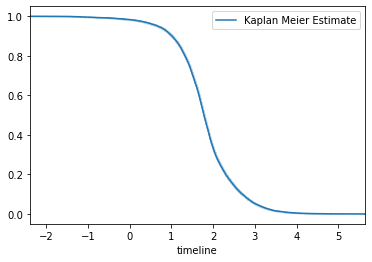

median q = 1.7773914927843641


In [273]:
det_name = 'q_fritz'
lim_name = 'q_pixel'
ldust_name = 'Ldust_bayes'


detected_data = detected_sample_en1[det_name]
mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][mask]
ldust_det = detected_sample_en1[ldust_name][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.ones(len(limit_data)))
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_survival_time_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_survival_time_))




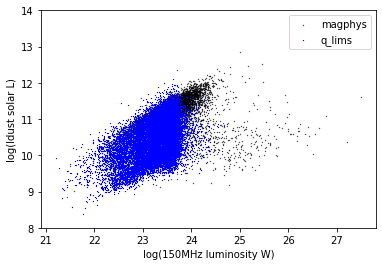

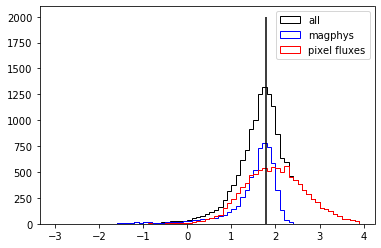

In [274]:
sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

x = np.log10(detected_sample_en1[rad_name])
y = np.log10(detected_sample_en1[ldust_name]/3.8E26)
plt.scatter(x,y,s=0.1,label='magphys',c='black')

y = np.log10(limit_sample_en1[ldust_lim_name]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name])
plt.scatter(x,y,s=0.1,label='q_lims',c='blue',marker='^')

plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust solar L)')
plt.ylim(8.0,14)
plt.legend()
plt.show()

bins = np.arange(-3,4,0.1)

plt.hist(np.append(detected_sample_en1[det_name],limit_sample_en1[lim_name]),label='all',bins=bins,histtype='step',color='black')
plt.hist(detected_sample_en1[det_name],label='magphys',bins=bins,histtype='step',color='blue')
plt.hist(limit_sample_en1[lim_name],label='pixel fluxes',bins=bins,histtype='step',color='red')
plt.vlines(kmf.median_survival_time_,0,2000)
plt.legend()
plt.show()

measured median from the detections is: 1.3181514633961235
measured median using survival analysis is: 1.9292427917854518


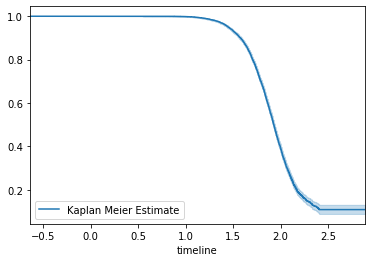

median q = 1.9292427917854518


In [290]:
det_name = 'q_fritz'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['optical_AGN'].astype(bool) | detected_sample_en1['radio_AGN'].astype(bool)

detected_data = detected_sample_en1[det_name][~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_survival_time_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_survival_time_))



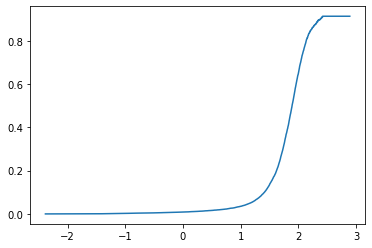

In [261]:
x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
plt.plot(x,y)

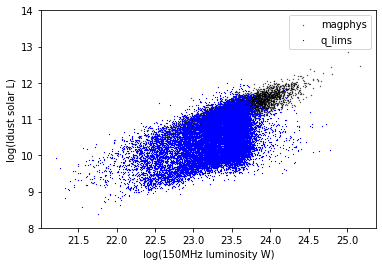

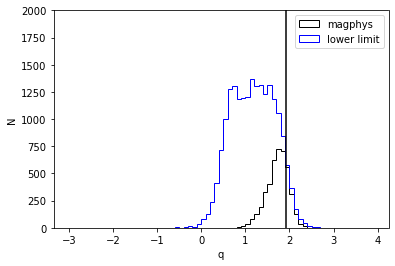

In [292]:
sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

x = np.log10(detected_sample_en1[rad_name][~agn_mask])
y = np.log10(detected_sample_en1[ldust_name][~agn_mask]/3.8E26)
plt.scatter(x,y,s=0.1,label='magphys',c='black')

y = np.log10(limit_sample_en1[ldust_lim_name]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name])
plt.scatter(x,y,s=0.1,label='q_lims',c='blue',marker='^')

plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust solar L)')
plt.ylim(8.0,14)
plt.legend()
plt.show()

bins = np.arange(-3,4,0.1)

plt.hist(detected_sample_en1[det_name][~agn_mask],label=sed_name,bins=bins,histtype='step',color='black')

plt.hist(limit_sample_en1[lim_name],label='lower limit',bins=bins,histtype='step',color='blue')
plt.vlines(kmf.median_survival_time_,0,2000)
plt.ylim(0,2000)
plt.xlabel('q')
plt.ylabel('N')
plt.legend()
plt.show()

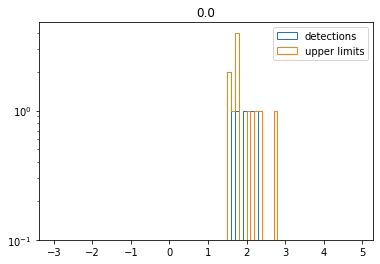

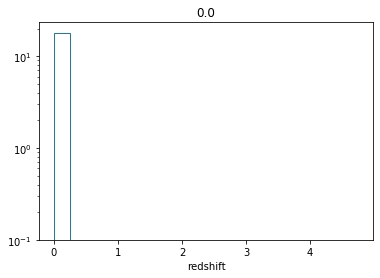

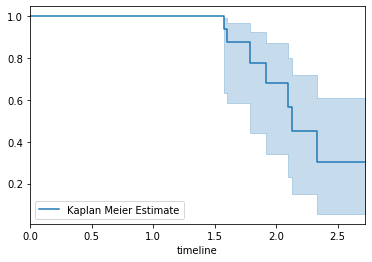

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


measured median using survival analysis is: 2.1301899987268946


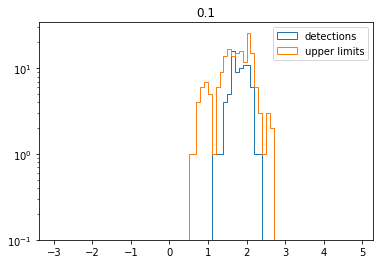

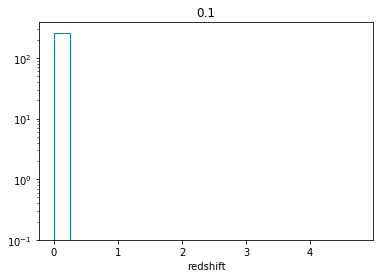

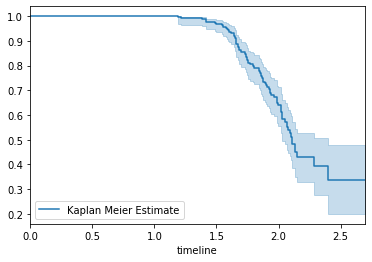

measured median using survival analysis is: 2.111180577764763


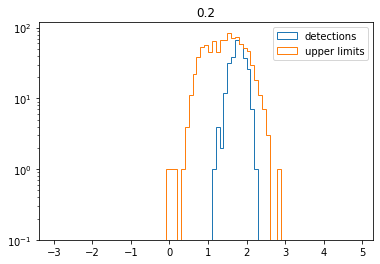

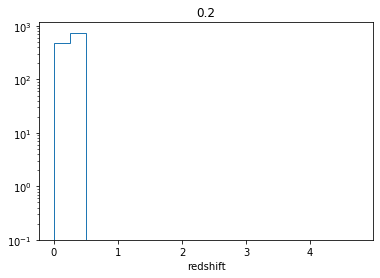

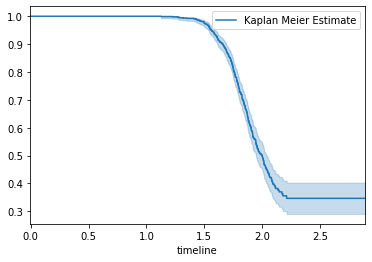

measured median using survival analysis is: 1.998225410829452


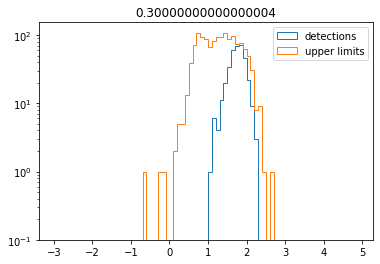

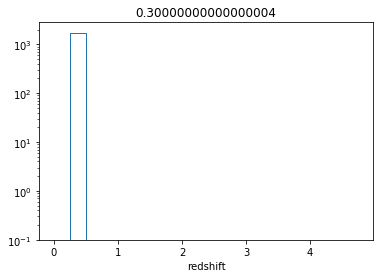

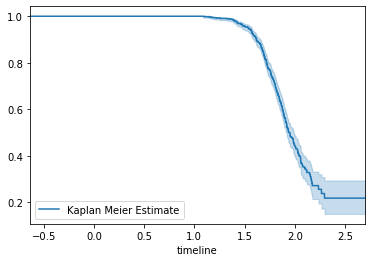

measured median using survival analysis is: 1.9427166233079873


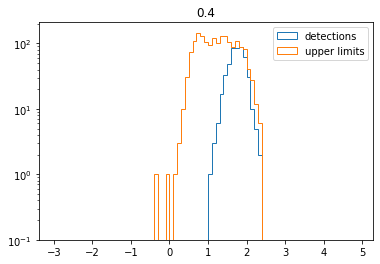

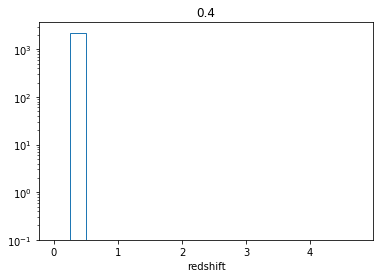

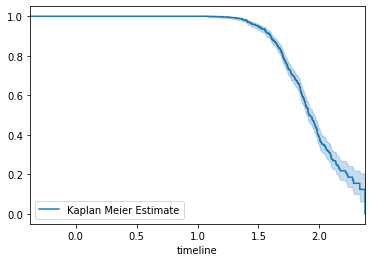

measured median using survival analysis is: 1.917477739198997


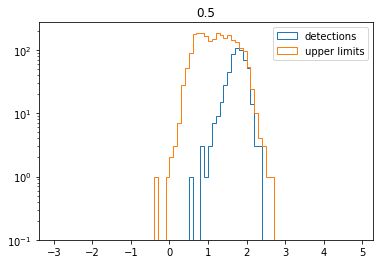

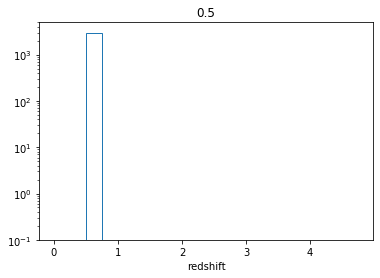

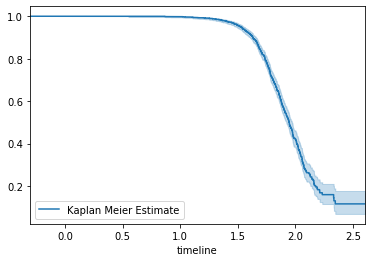

measured median using survival analysis is: 1.9448054244061872


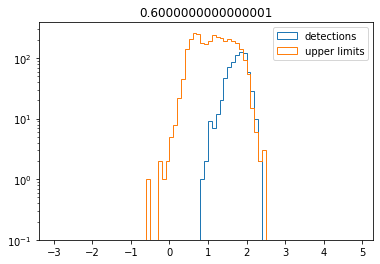

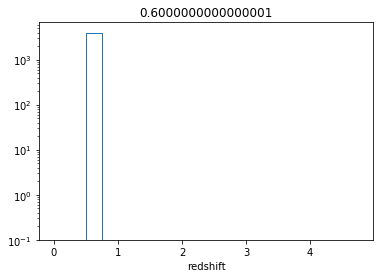

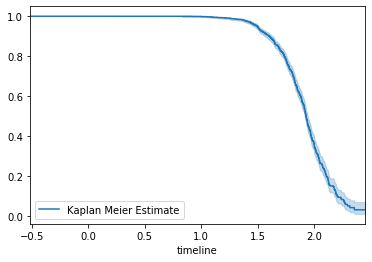

measured median using survival analysis is: 1.9292865433264126


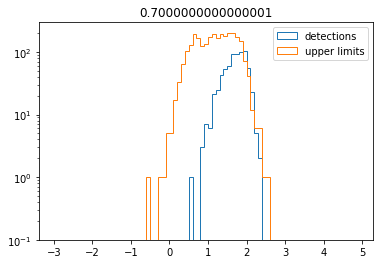

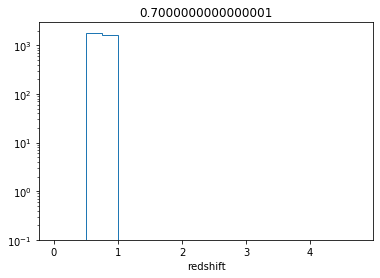

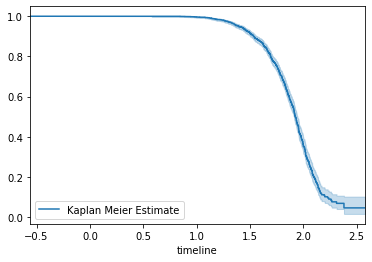

measured median using survival analysis is: 1.9243402839999284


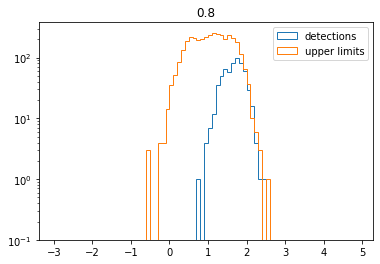

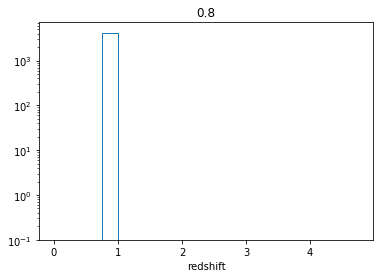

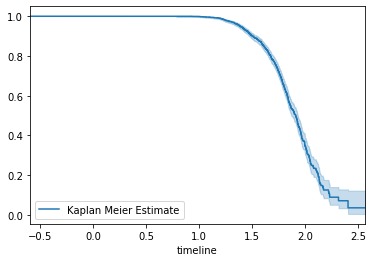

measured median using survival analysis is: 1.9112590635235094


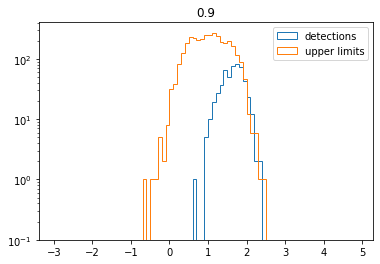

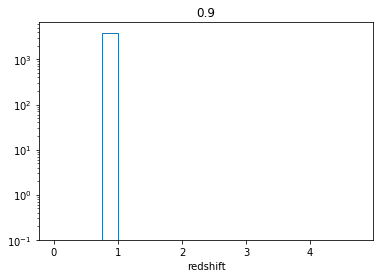

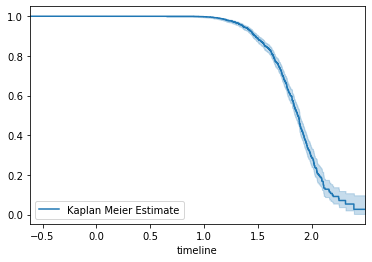

measured median using survival analysis is: 1.8694161249458041


In [293]:
bins_z = np.arange(0,1.0,0.1)

redshifts = np.append(redshift_det,redshift_lim)

test = np.digitize(redshifts,bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

ras_binned = []
decs_binned = []
redshift_binned = []
mean_q_agnfitter = []
for n,num in enumerate(nums_z):
    mask = (test==num) #& (redshift_all<np.max(redshift))
    q_vals = data[mask]
    q_det = det[mask]
    q_lims = data[mask][~det[mask].astype(bool)]
    
    redshift_binned.append(redshifts[mask])
    
    bins = np.arange(-3,5,0.1)
    plt.hist(q_vals[det[mask].astype(bool)],log=True,label='detections',bins=bins,histtype='step')
    plt.hist(q_lims,log=True,label='upper limits',bins=bins,histtype='step')
    plt.title('{}'.format(bins_z[n]))
    plt.legend()
    plt.show()
    
    plt.hist(redshifts[mask],bins=np.arange(0,5,0.25),log=True,histtype='step')
    plt.xlabel('redshift')
    plt.title('{}'.format(bins_z[n]))
    plt.show()
    
    
    kmf = KaplanMeierFitter()
    kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
    kmf.plot()
    plt.show()
    print('measured median using survival analysis is: {}'.format(kmf.median_))
    
    mean_q_agnfitter.append(kmf.median_)

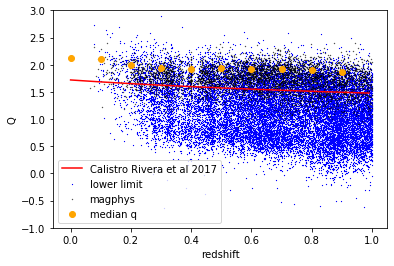

In [294]:
mask_det = det.astype(bool)
x = redshifts[~mask_det]
y = data[~mask_det]
plt.scatter(x,y,s=0.1,marker='^',label='lower limit',c='blue')

x = redshifts[mask_det]
y = data[mask_det]
plt.scatter(x,y,s=0.1,label=sed_name,c='black')

x = bins_z[nums_z-1]
y = mean_q_agnfitter
plt.scatter(x,y,label='median q',c='orange')

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

In [295]:
x = bins_z[nums_z-1]
y = calistro_fit(x)
dif = np.mean(mean_q_agnfitter - y)
print(dif)

0.37418105242857036


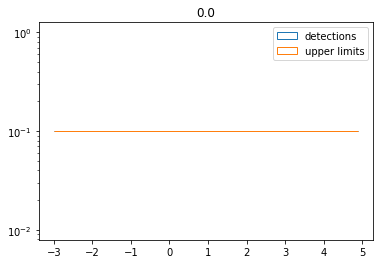

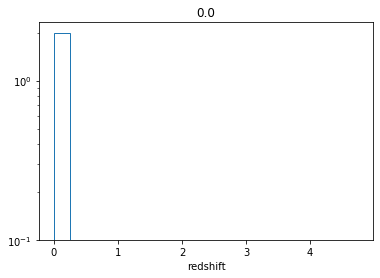

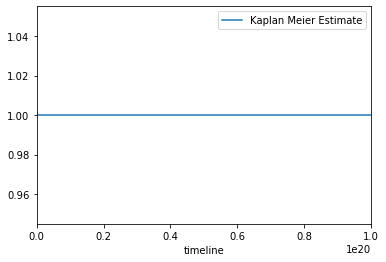

measured median using survival analysis is: inf


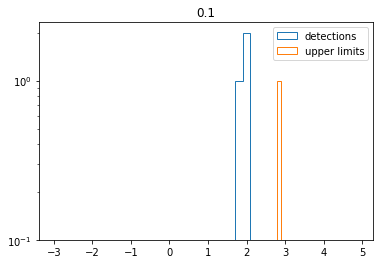

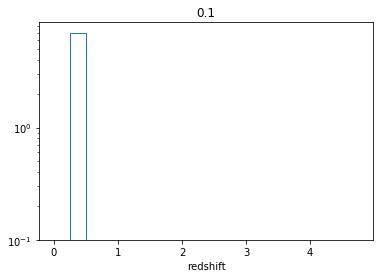

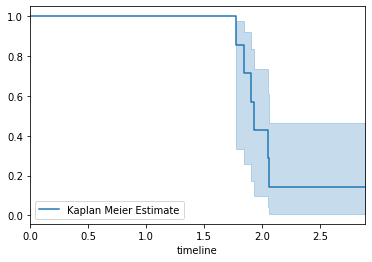

measured median using survival analysis is: 1.9323774797730415


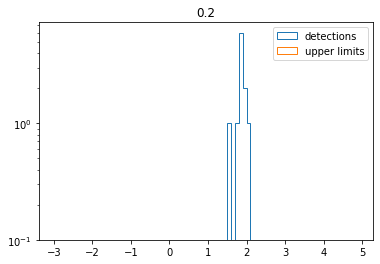

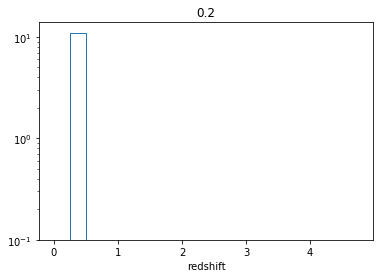

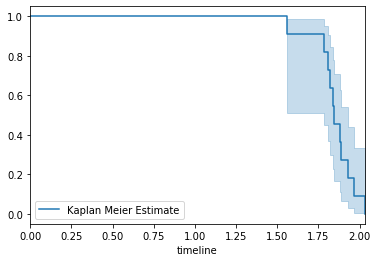

measured median using survival analysis is: 1.8440118239177004


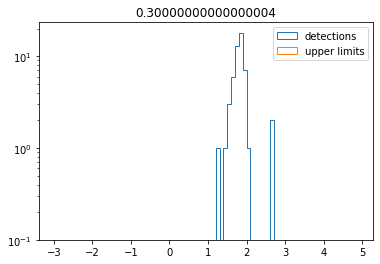

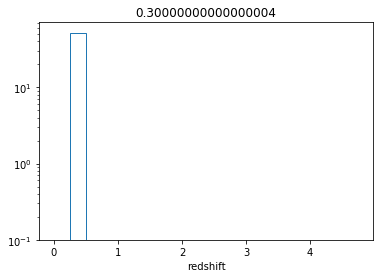

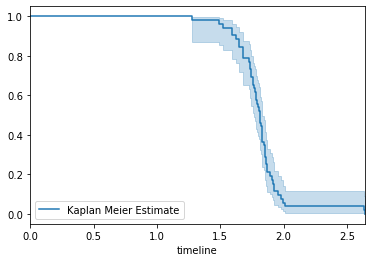

measured median using survival analysis is: 1.8141835439538347


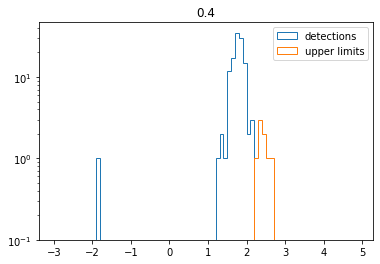

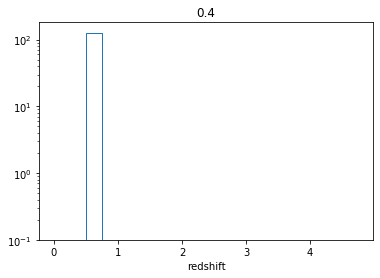

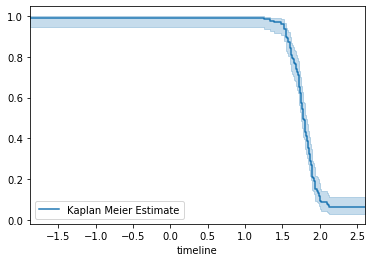

measured median using survival analysis is: 1.780831106947101


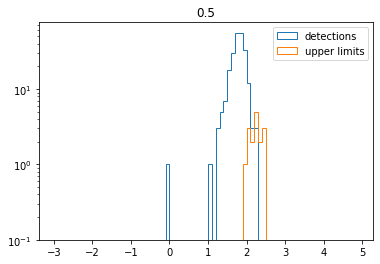

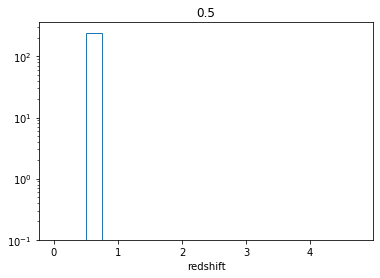

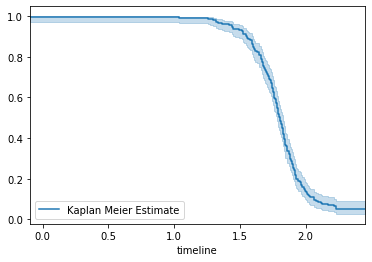

measured median using survival analysis is: 1.8047219493764999


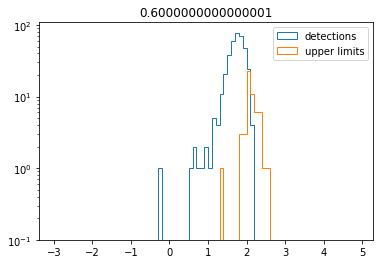

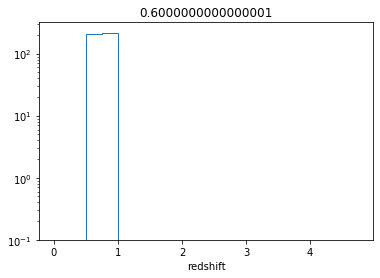

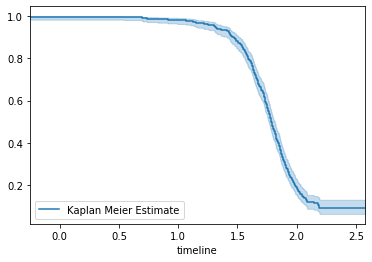

measured median using survival analysis is: 1.7867943777723916


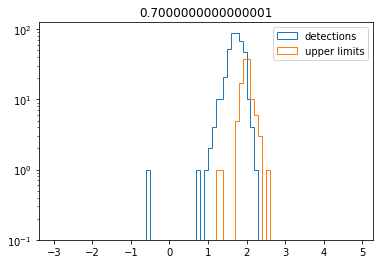

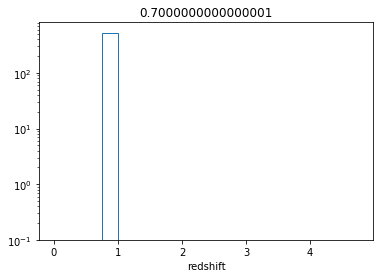

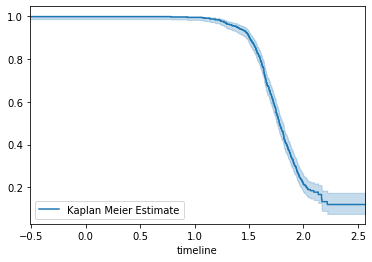

measured median using survival analysis is: 1.7798620025124592


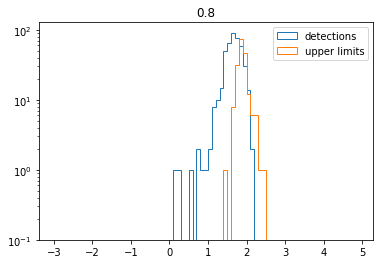

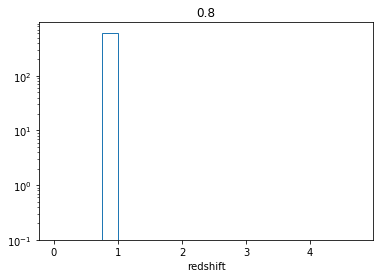

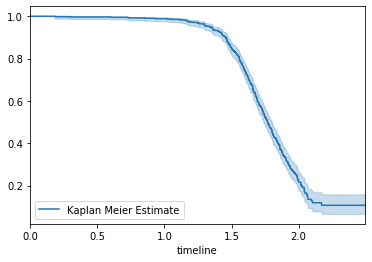

measured median using survival analysis is: 1.7690780830092514


In [47]:
bins_z = np.arange(0,1.0,0.1)

redshifts = np.append(redshift_det,redshift_lim)
ldusts = np.append(np.log10(ldust_det),np.log10(ldust_lim))

mask_ldust = ldusts>38

test = np.digitize(redshifts[mask_ldust],bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

ras_binned = []
decs_binned = []
redshift_binned = []
mean_q = []
for n,num in enumerate(nums_z):
    mask = (test==num) #& (redshift_all<np.max(redshift))
    q_vals = data[mask_ldust][mask]
    q_det = det[mask_ldust][mask]
    q_lims = data[mask_ldust][mask][~det[mask_ldust][mask].astype(bool)]
    
    redshift_binned.append(redshifts[mask_ldust][mask])
    
    bins = np.arange(-3,5,0.1)
    plt.hist(q_vals[det[mask_ldust][mask].astype(bool)],log=True,label='detections',bins=bins,histtype='step')
    plt.hist(q_lims,log=True,label='upper limits',bins=bins,histtype='step')
    plt.title('{}'.format(bins_z[n]))
    plt.legend()
    plt.show()
    
    plt.hist(redshifts[mask_ldust][mask],bins=np.arange(0,5,0.25),log=True,histtype='step')
    plt.xlabel('redshift')
    plt.title('{}'.format(bins_z[n]))
    plt.show()
    
    
    kmf = KaplanMeierFitter()
    kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
    kmf.plot()
    plt.show()
    print('measured median using survival analysis is: {}'.format(kmf.median_))
    
    mean_q.append(kmf.median_)

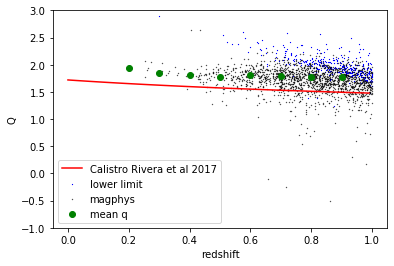

In [48]:
mask_det = det.astype(bool)
mask_bright = ldusts>38
x = redshifts[~mask_det & mask_bright]
y = data[~mask_det & mask_bright]
plt.scatter(x,y,s=0.1,marker='^',label='lower limit',c='blue')

x = redshifts[mask_det& mask_bright]
y = data[mask_det& mask_bright]
plt.scatter(x,y,s=0.1,label=sed_name,c='black')

x = bins_z[nums_z-1]
y = mean_q
plt.scatter(x,y,label='mean q',c='green')

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

## Compare with Lingyu's results

In [165]:
lingyu_ir_results = Table.read('../../lofar/deep_fields/ELAIS-N1/data/IR_lum_sources_lingyu/lingyu_en1/multi_en1_18_final_overlap.fits', character_as_bytes=False)
lingyu_ir_results[0]
lingyu_join = join(lingyu_ir_results,lofar_sed_en1,keys='Source_Name',table_names=['XID','lingyu'])
print(len(lingyu_join))
lingyu_join[0]

1266


index_SPIRE,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,RA_pix,Dec_pix,Source_id,RA_lofar_b,DEC_lofar_b,Total_flux_1,E_Total_flux_1,GroupID,GroupSize,Separation_1,Source_Name,RA_lofar_f,DEC_lofar_f,Total_flux_2,E_Total_flux_2,Peak_flux_XID,E_Peak_flux_XID,flag_clean_XID,FLAG_OVERLAP_XID,u_flux_corr_XID,u_fluxerr_corr_XID,g_flux_corr_XID,g_fluxerr_corr_XID,r_flux_corr_XID,r_fluxerr_corr_XID,i_flux_corr_XID,i_fluxerr_corr_XID,z_flux_corr_XID,z_fluxerr_corr_XID,y_flux_corr_XID,y_fluxerr_corr_XID,g_hsc_flux_corr_XID,g_hsc_fluxerr_corr_XID,r_hsc_flux_corr_XID,r_hsc_fluxerr_corr_XID,i_hsc_flux_corr_XID,i_hsc_fluxerr_corr_XID,z_hsc_flux_corr_XID,z_hsc_fluxerr_corr_XID,y_hsc_flux_corr_XID,y_hsc_fluxerr_corr_XID,nb921_hsc_flux_corr_XID,nb921_hsc_fluxerr_corr_XID,J_flux_corr_XID,J_fluxerr_corr_XID,K_flux_corr_XID,K_fluxerr_corr_XID,ch1_swire_flux_corr_XID,ch1_swire_fluxerr_corr_XID,ch2_swire_flux_corr_XID,ch2_swire_fluxerr_corr_XID,ch3_swire_flux_corr_XID,ch3_swire_fluxerr_corr_XID,ch4_swire_flux_corr_XID,ch4_swire_fluxerr_corr_XID,ch1_servs_flux_corr_XID,ch1_servs_fluxerr_corr_XID,ch2_servs_flux_corr_XID,ch2_servs_fluxerr_corr_XID,Separation_2,help_id_XID,CLASS_STAR_XID,F_MIPS_24_XID,FErr_MIPS_24_u_XID,FErr_MIPS_24_l_XID,flag_mips_24_XID,F_PACS_100_XID,FErr_PACS_100_u_XID,FErr_PACS_100_l_XID,F_PACS_160_XID,FErr_PACS_160_u_XID,FErr_PACS_160_l_XID,flag_PACS_100_XID,flag_PACS_160_XID,F_SPIRE_250_XID,FErr_SPIRE_250_u_XID,FErr_SPIRE_250_l_XID,F_SPIRE_350_XID,FErr_SPIRE_350_u_XID,FErr_SPIRE_350_l_XID,F_SPIRE_500_XID,FErr_SPIRE_500_u_XID,FErr_SPIRE_500_l_XID,Z_BEST_XID,Z_BEST_SOURCE_XID,Z_SPEC_XID,z1_median_XID,z1_min_XID,z1_max_XID,z1_area_XID,z2_median_XID,z2_min_XID,z2_max_XID,z2_area_XID,chi_r_best_XID,AGN_XID,optAGN_XID,IRAGN_XID,XrayAGN_XID,Mass_median_XID,Separation_XID,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux_lingyu,E_Peak_flux_lingyu,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean_lingyu,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP_lingyu,u_flux_corr_lingyu,u_fluxerr_corr_lingyu,u_mag_corr,u_magerr_corr,g_flux_corr_lingyu,g_fluxerr_corr_lingyu,g_mag_corr,g_magerr_corr,r_flux_corr_lingyu,r_fluxerr_corr_lingyu,r_mag_corr,r_magerr_corr,i_flux_corr_lingyu,i_fluxerr_corr_lingyu,i_mag_corr,i_magerr_corr,z_flux_corr_lingyu,z_fluxerr_corr_lingyu,z_mag_corr,z_magerr_corr,y_flux_corr_lingyu,y_fluxerr_corr_lingyu,y_mag_corr,y_magerr_corr,g_hsc_flux_corr_lingyu,g_hsc_fluxerr_corr_lingyu,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr_lingyu,r_hsc_fluxerr_corr_lingyu,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr_lingyu,i_hsc_fluxerr_corr_lingyu,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr_lingyu,z_hsc_fluxerr_corr_lingyu,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr_lingyu,y_hsc_fluxerr_corr_lingyu,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr_lingyu,nb921_hsc_fluxerr_corr_lingyu,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr_lingyu,J_fluxerr_corr_lingyu,J_mag_corr,J_magerr_corr,K_flux_corr_lingyu,K_fluxerr_corr_lingyu,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr_lingyu,ch1_swire_fluxerr_corr_lingyu,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr_lingyu,ch2_swire_fluxerr_corr_lingyu,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr_lingyu,ch3_swire_fluxerr_corr_lingyu,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr_lingyu,ch4_swire_fluxerr_corr_lingyu,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr_lingyu,ch1_servs_fluxerr_corr_lingyu,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr_lingyu,ch2_servs_fluxerr_corr_lingyu,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation_lingyu,help

In [167]:
np.sum(lingyu_join['radio_AGN'].astype(bool) & np.sum(lingyu_join['optical_AGN'].astype(bool)))

206

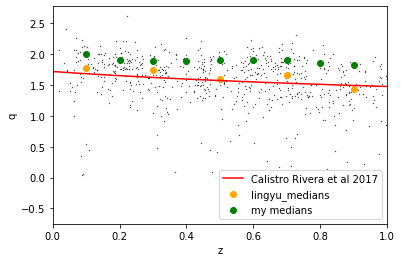

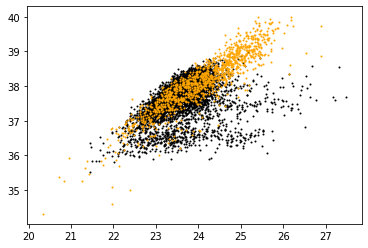

In [162]:
x = lingyu_join['Z_BEST_XID']
y = lingyu_join['q_fritz']
mask = (~np.isnan(x)) & (~np.isinf(x)) & (~np.isnan(y)) & (~np.isinf(y))
x = x[mask]
y = y[mask]
plt.scatter(x,y,c='black',s=0.1)

bins = np.arange(0,6,0.2)
medians,_,_ = binned_statistic(x,y,'median',bins=bins)
centers = get_center(bins)
plt.scatter(centers,medians,c='orange',label='lingyu_medians')

x = bins_z[nums_z-1]
y = mean_q_agnfitter
plt.scatter(x,y,c='green',label='my medians')

x = np.arange(0,6,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.xlim(0,1)
plt.legend()
plt.xlabel('z')
plt.ylabel('q')
plt.show()


x = np.log10(detected_sample_en1['radio_luminosity'])
y = np.log10(detected_sample_en1['bayes.dust.luminosity_fritz'])
plt.scatter(x,y,c='black',s=1)

x = np.log10(lingyu_join['radio_luminosity'])
y = np.log10(lingyu_join['bayes.dust.luminosity_fritz'])
plt.scatter(x,y,c='orange',s=1)
plt.show()

#### x = np.log10(detected_sample_en1['radio_luminosity'])
y = np.log10(detected_sample_en1['bayes.dust.luminosity_fritz'])
binsx = np.arange(21,27,0.25)
binsy = np.arange(35,40,0.25)
image,_,_ = np.histogram2d(x,y,bins=[binsx,binsy])
plt.contour(image,colors='black',label='lofar')
#plt.scatter(x,y,c='black',s=1)

x = np.log10(lingyu_join['radio_luminosity'])
y = np.log10(lingyu_join['bayes.dust.luminosity_fritz'])
binsx = np.arange(21,27,0.25)
binsy = np.arange(35,40,0.25)
image,_,_ = np.histogram2d(x,y,bins=[binsx,binsy])
plt.contour(image,colors='red',label='lingyu')
#plt.scatter(x,y,c='orange',s=1)
plt.legend()
plt.show()

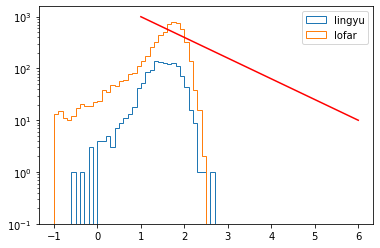

In [157]:
bins=np.arange(-1,3,0.1)
y = lingyu_join['q_fritz']
plt.hist(y,bins=bins,log=True,histtype='step',label='lingyu')

y = detected_sample_en1['q_fritz']
plt.hist(y,bins=bins,log=True,histtype='step',label='lofar')
plt.legend()
plt.show()

In [149]:
np.median(y)

1.652859443303452

## Measure FIRC for different LIR selections

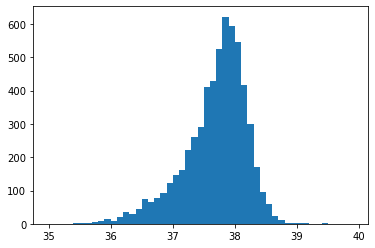

In [84]:
y = np.log10(detected_sample_en1['Ldust_bayes'])
bins = np.arange(35,40,0.1)
plt.hist(y,bins=bins)
plt.show()

measured median from the detections is: 1.779108068506666
measured median using survival analysis is: 1.78667356157953


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


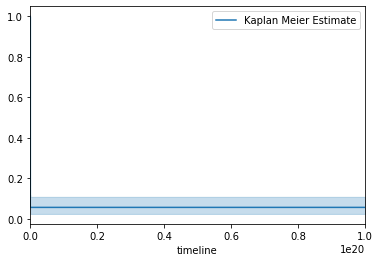

median q = 1.78667356157953


In [85]:
mask_det_lir = detected_sample_en1['Ldust_bayes']>1E38
mask_lim_lir = limit_sample_en1['Ldust_bayes']>1E38
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


detected_data = detected_sample_en1[det_name]
mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][mask]
ldust_det = detected_sample_en1[ldust_name][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_))




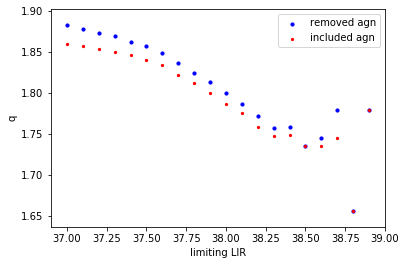

In [114]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['optical_AGN'].astype(bool) | detected_sample_en1['radio_AGN'].astype(bool)

lir_bins = np.arange(37,39,0.1)
median_q_lir_no_agn = []
for n,lir_lim in enumerate(lir_bins):
    mask_det_lir = (np.log10(detected_sample_en1['Ldust_bayes'])>lir_lim) & (~agn_mask)
    mask_lim_lir = (np.log10(limit_sample_en1['Ldust_bayes'])>lir_lim)


    detected_data = detected_sample_en1[det_name]
    mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][mask]
    ldust_det = detected_sample_en1[ldust_name][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
    #print('measured median from the detections is: {}'.format(np.median(data)))

    kmf = KaplanMeierFitter() 

## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    #print('median q = {}'.format(kmf.median_))

    median_q_lir_no_agn.append(kmf.median_)
    
lir_bins = np.arange(37,39,0.1)
median_q_lir = []
for n,lir_lim in enumerate(lir_bins):
    mask_det_lir = (np.log10(detected_sample_en1['Ldust_bayes'])>lir_lim)
    mask_lim_lir = (np.log10(limit_sample_en1['Ldust_bayes'])>lir_lim)


    detected_data = detected_sample_en1[det_name]
    mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][mask]
    ldust_det = detected_sample_en1[ldust_name][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
    #print('measured median from the detections is: {}'.format(np.median(data)))

    kmf = KaplanMeierFitter() 

## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    #print('median q = {}'.format(kmf.median_))

    median_q_lir.append(kmf.median_)

x = lir_bins
y = median_q_lir_no_agn
plt.scatter(x,y,label='removed agn',c='blue',s=10)
x = lir_bins
y = median_q_lir
plt.scatter(x,y,label='included agn',c='red',s=5)
plt.xlabel('limiting LIR')
plt.ylabel('q')
plt.legend()
plt.show()

In [103]:
np.sum(mask_det_lir)

5

In [102]:
np.sum(detected_sample_en1['radio_AGN'].astype(bool))

1617